# Fake Review Detection

In [23]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sqlite3
import re
from datetime import datetime
from tqdm import tqdm
from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

import nltk
import swifter
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [25]:
# load preprocessed data
df = pd.read_pickle('../data/processed_df.pkl')

# EDA
## Overview

In [26]:
df.flagged.value_counts()

YR    223414
NR    187966
Name: flagged, dtype: int64

Assign class labels.

1： fake review, 
0:  true revoew

In [27]:
df.loc[df['flagged'] == 'YR', 'flagged'] = 1
df.loc[df['flagged'] == 'NR', 'flagged'] = 0

In [28]:
real = df[df.flagged == 0]
fake = df[df.flagged == 1]

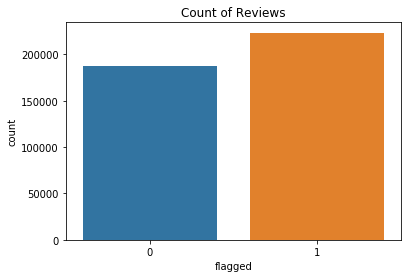

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='flagged', data=df)
plt.title("Count of Reviews")
plt.show()

In [30]:
# check if every review is unique
df.reviewID.nunique() == df.shape[0]

True

In [31]:
# total number of unique reviews
df.shape[0]

411380

In [32]:
# check the number of unique reviewers
df.reviewerID.nunique()

14321

In [33]:
# check the locations
df.location.value_counts()

Chicago, IL             135047
San Francisco, CA        30996
Los Angeles, CA          14517
New York, NY             13549
Boston, MA                5389
                         ...  
Fort Myers Beach, FL         1
Lake, IL                     1
East Orange, NJ              1
Kenwood, CA                  1
PECK SLIP, NY                1
Name: location, Length: 1361, dtype: int64

In [34]:
# check number of restaurants
df.restaurantID.nunique()

114625

## Review Columns EDA
### Review Date Exploration

In [35]:
df.date.describe()

count                  411380
unique                   2802
top       2009-02-08 00:00:00
freq                      542
first     2004-10-12 00:00:00
last      2012-10-22 00:00:00
Name: date, dtype: object

C:\Users\BD\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


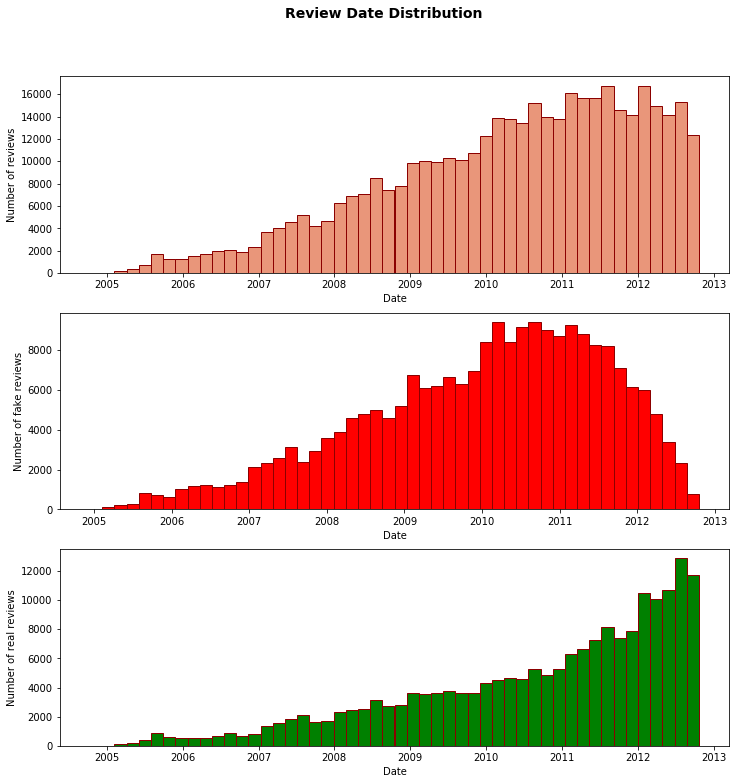

In [36]:
# Prepare the figure
fig = plt.figure( figsize=(12,12) )
title = fig.suptitle("Review Date Distribution", fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.9, wspace=0.3)

# Prepare a subplot
ax = fig.add_subplot(3,1,1) # https://youtu.be/afITiFR6vfw?t=1m53s
ax.set_xlabel("Date")
ax.set_ylabel("Number of reviews")

# Add text into the subplot
freq, bins, patches = ax.hist(df['date'], 
                              bins=50,
                              color='darksalmon', 
                              edgecolor='darkred', linewidth=1.0)

# Prepare a subplot
ax2 = fig.add_subplot(3,1,2) 
ax2.set_ylabel("Number of fake reviews")
ax2.set_xlabel("Date")

# Add text into the subplot
freq, bins, patches = ax2.hist(fake['date'], 
                              bins=50,
                              color='red', 
                              edgecolor='darkred', linewidth=1.0)
# Prepare a subplot
ax3 = fig.add_subplot(3,1,3) 
ax3.set_ylabel("Number of real reviews")
ax3.set_xlabel("Date")

# Add text into the subplot
freq, bins, patches = ax3.hist(real['date'], 
                              bins=50,
                              color='green', 
                              edgecolor='darkred', linewidth=1.0)

### Review Rating Exploration

In [37]:
# check review ratings
df.review_rating.value_counts()

4    161943
3     94693
5     92069
2     42179
1     20496
Name: review_rating, dtype: int64

Total review count:  411380
Total fake reviews:  223414
Total real reviews:  187966


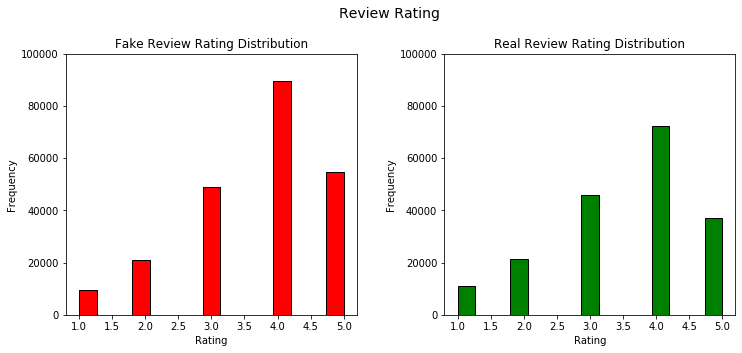

In [38]:
fig = plt.figure(figsize = (12,5))
title = fig.suptitle("Review Rating", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Fake Review Rating Distribution")
ax1.set_xlabel("Rating")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 100000])
print('Total review count: ', df.shape[0])
print('Total fake reviews: ' ,fake.shape[0])
r_freq, r_bins, r_patches = ax1.hist(fake['review_rating'], color='red', bins=15,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Real Review Rating Distribution")
ax2.set_xlabel("Rating")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 100000])
print('Total real reviews: ' ,real.shape[0])
w_freq, w_bins, w_patches = ax2.hist(real['review_rating'], color='green', bins=15,
                                     edgecolor='black', linewidth=1)

In [39]:
ave_all_rating = df.review_rating.mean()
ave_fake_rating = fake.review_rating.mean()
ave_real_rating = real.review_rating.mean()
print('Average rating for all reviews: ', round(ave_all_rating,2))
print('Average rating for fake reviews: ', round(ave_fake_rating,2))
print('Average rating for real reviews: ', round(ave_real_rating,2))

Average rating for all reviews:  3.64
Average rating for fake reviews:  3.71
Average rating for real reviews:  3.55


### Review usefulCount Exploration (includes other counts)

Average total reviews useful counts:  1.43
Average fake reviews useful counts:  1.22
Average real reviews useful counts:  1.69


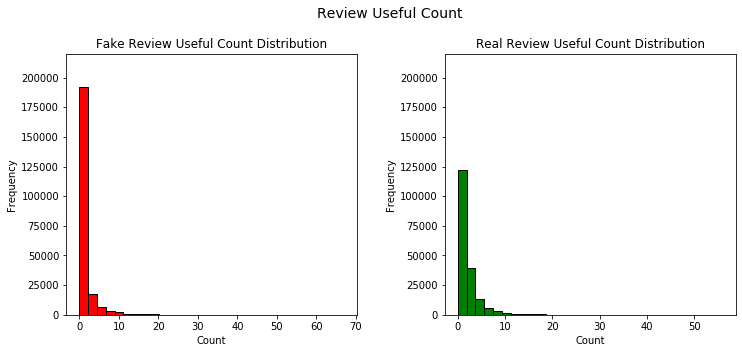

In [40]:
fig = plt.figure(figsize = (12,5))
title = fig.suptitle("Review Useful Count", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Fake Review Useful Count Distribution")
ax1.set_xlabel("Count")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 220000])
print('Average total reviews useful counts: ', round(df['review_usefulCount'].mean(),2))
print('Average fake reviews useful counts: ' ,round(fake['review_usefulCount'].mean(),2))
r_freq, r_bins, r_patches = ax1.hist(fake['review_usefulCount'], color='red', bins=30,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Real Review Useful Count Distribution")
ax2.set_xlabel("Count")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 220000])
print('Average real reviews useful counts: ' ,round(real['review_usefulCount'].mean(),2))
w_freq, w_bins, w_patches = ax2.hist(real['review_usefulCount'], color='green', bins=30,
                                     edgecolor='black', linewidth=1)

Average total reviews Cool counts:  0.95
Average fake reviews Cool counts:  0.85
Average real reviews Cool counts:  1.06


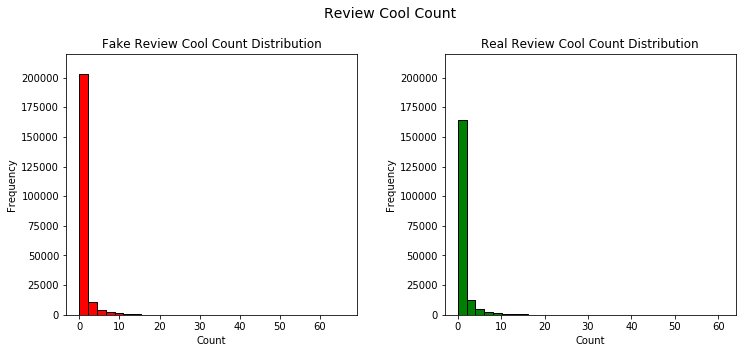

In [41]:
fig = plt.figure(figsize = (12,5))
title = fig.suptitle("Review Cool Count", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Fake Review Cool Count Distribution")
ax1.set_xlabel("Count")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 220000])
print('Average total reviews Cool counts: ', round(df['review_coolCount'].mean(),2))
print('Average fake reviews Cool counts: ' ,round(fake['review_coolCount'].mean(),2))
r_freq, r_bins, r_patches = ax1.hist(fake['review_coolCount'], color='red', bins=30,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Real Review Cool Count Distribution")
ax2.set_xlabel("Count")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 220000])
print('Average real reviews Cool counts: ' ,round(real['review_coolCount'].mean(),2))
w_freq, w_bins, w_patches = ax2.hist(real['review_coolCount'], color='green', bins=30,
                                     edgecolor='black', linewidth=1)

Average total reviews funny counts:  0.77
Average fake reviews funny counts:  0.67
Average real reviews funny counts:  0.89


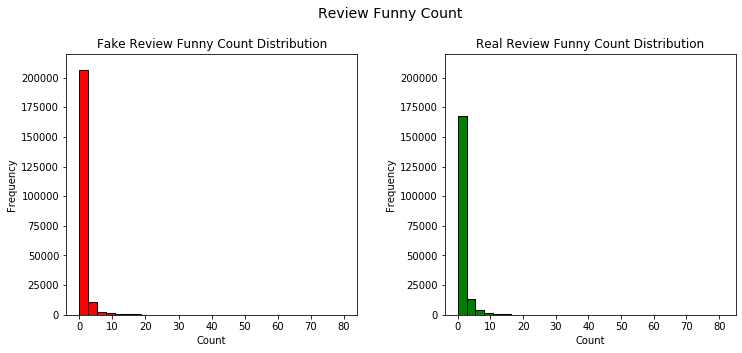

In [42]:
fig = plt.figure(figsize = (12,5))
title = fig.suptitle("Review Funny Count", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Fake Review Funny Count Distribution")
ax1.set_xlabel("Count")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 220000])
print('Average total reviews funny counts: ', round(df['review_funnyCount'].mean(),2))
print('Average fake reviews funny counts: ' ,round(fake['review_funnyCount'].mean(),2))
r_freq, r_bins, r_patches = ax1.hist(fake['review_funnyCount'], color='red', bins=30,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Real Review Funny Count Distribution")
ax2.set_xlabel("Count")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 220000])
print('Average real reviews funny counts: ' ,round(real['review_funnyCount'].mean(),2))
w_freq, w_bins, w_patches = ax2.hist(real['review_funnyCount'], color='green', bins=30,
                                     edgecolor='black', linewidth=1)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

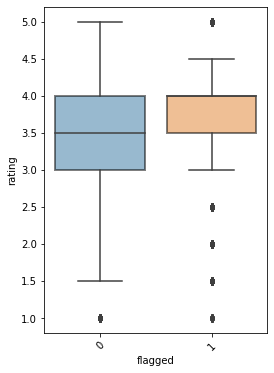

In [43]:
plt.figure(figsize = (4, 6))
ax = sns.boxplot(x='flagged', y='rating', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

## Reviewer Columns EDA
### FriendCount

Fake review ratio:
The number of reviews filtered as fake review / total number of reviews by the reviewer

In [44]:
df.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating',
       'review_usefulCount', 'review_coolCount', 'review_funnyCount',
       'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
       'funnyCount', 'complimentCount', 'tipCount', 'fanCount',
       'restaurant_name', 'rating', 'processed_text'],
      dtype='object')

In [45]:
cols = ['reviewerID','reviewer_name','location', 'yelpJoinDate',
        'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
        'funnyCount', 'complimentCount', 'tipCount', 'fanCount']

df_reviewer = df.groupby(['reviewerID'], as_index = False)['flagged'].agg({'total_review':'count', 'fake_review': 'sum'})
df_reviewer['fake_review_ratio'] = df_reviewer['fake_review']/df_reviewer['total_review']
df_reviewer = df_reviewer.merge(df[cols].drop_duplicates(subset = 'reviewerID'), on = 'reviewerID', how='inner')

In [46]:
# get a df with all the reviewers information
df_reviewer.head()

,reviewerID,total_review,fake_review,fake_review_ratio,reviewer_name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount
0,--KQJPdrU0Md97DiOliDzw,130,79,0.607692,Steven C.,"Bellerose, NY",2006-01-01,87,163,9,277,169,140,135,13,5
1,--KXo_HCYq9hB8NOdEUMKw,2,2,1.000000,Megan MJ J.,"Chicago, IL",2010-01-04,12,4,0,1,1,0,1,0,1
2,--Qh8yKWAvIP4V4K8ZPfHA,55,2,0.036364,Dixie cream tea Q.,"Toronto, ON",2011-01-01,15,161,21,80,56,32,50,20,2
3,--cDU5woxccqoHW5jzxJBw,4,4,1.000000,Brian J.,"Chicago, IL",2008-01-05,7,10,0,12,3,1,2,0,0
4,--eQVss9nAx54FWsZHZgpA,11,9,0.818182,Kc Wildman W.,"Boulder, CO",2010-01-05,46,12,0,7,2,2,1,2,1


In [47]:
df_reviewer.columns

Index(['reviewerID', 'total_review', 'fake_review', 'fake_review_ratio',
       'reviewer_name', 'location', 'yelpJoinDate', 'friendCount',
       'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount',
       'complimentCount', 'tipCount', 'fanCount'],
      dtype='object')

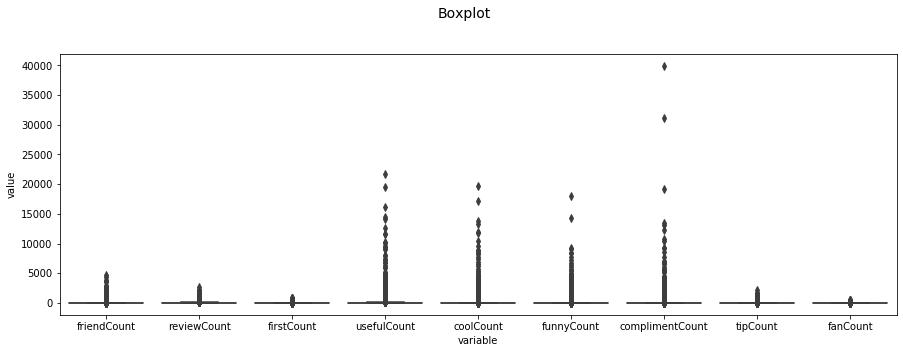

In [48]:
fig = plt.figure(figsize = (15,5))
title = fig.suptitle("Boxplot", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
ax1 = fig.add_subplot(1,1, 1)
sns.boxplot(x="variable", y="value", data=pd.melt(df_reviewer[['friendCount','reviewCount', 'firstCount', 'usefulCount',
                                                              'coolCount', 'funnyCount','complimentCount', 'tipCount', 'fanCount']]))

Either convert the features to categorical variables by binning them or use standard scaler.

### Fake Review Ratio

In [49]:
# all reviewers who have ever given fake reviews
threshold = 0.3
df_reviewer_fake = df_reviewer[df_reviewer.fake_review_ratio > threshold]

count    12470.000000
mean         0.777735
std          0.225345
min          0.300518
25%          0.590909
50%          0.815207
75%          1.000000
max          1.000000
Name: fake_review_ratio, dtype: float64


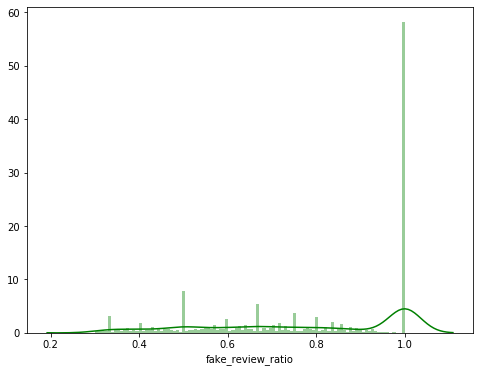

In [50]:
print(df_reviewer_fake['fake_review_ratio'].describe())
plt.figure(figsize=(8, 6))
sns.distplot(df_reviewer_fake['fake_review_ratio'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Restaurant Columns EDA

In [51]:
df.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating',
       'review_usefulCount', 'review_coolCount', 'review_funnyCount',
       'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
       'funnyCount', 'complimentCount', 'tipCount', 'fanCount',
       'restaurant_name', 'rating', 'processed_text'],
      dtype='object')

In [52]:
#Total number of unique business categories in the dataset
df['restaurant_name'].nunique()

86594

In [53]:
cols = ['restaurantID', 'restaurant_name']

df_restaurant = df.groupby(['restaurantID'], as_index = False)['flagged'].agg({'res_total_review':'count', 'res_fake_review': 'sum'})
df_restaurant['res_fake_review_ratio'] = df_restaurant['res_fake_review']/df_restaurant['res_total_review']
df_restaurant = df_restaurant.merge(df[cols].drop_duplicates(subset = 'restaurantID'), on = 'restaurantID', how='inner')

In [54]:
df_restaurant.head()

,restaurantID,res_total_review,res_fake_review,res_fake_review_ratio,restaurant_name
0,--164t1nclzzmca7eDiJMw,1,1,1.0,Me So Hungry
1,--1AMHXt89gtrEaB-Ea7Mw,1,0,0.0,Casablanca Middle Eastern Restaurant
2,--4m48NzUAHvTd4v0u5YIg,4,2,0.5,Christian's Tailgate Grill
3,--6MefnULPED_I942VcFNA,1,0,0.0,John's Chinese BBQ Restaurant
4,--6Tns3-YL6hHn6IbQi5vg,1,0,0.0,Taqueria Jesus Maria


Text(0.5, 0.98, 'Top 10 Most Reviewed Restaurants')

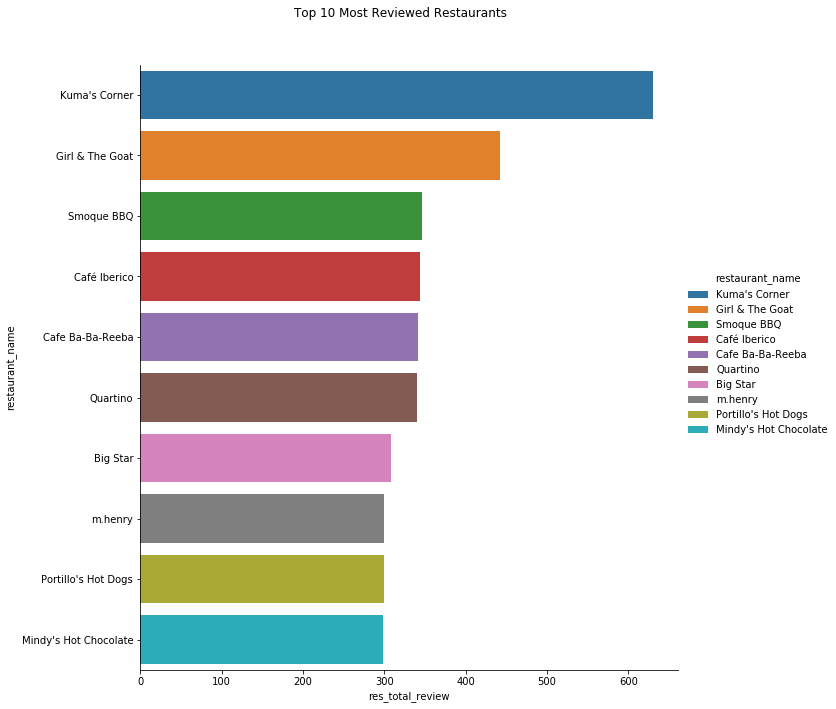

In [55]:
#Plotting top 20 most reviewed businesses among all categories
ax = sns.catplot(x="res_total_review", y="restaurant_name",data= df_restaurant.nlargest(10,'res_total_review'), 
                 kind="bar",hue= "restaurant_name", dodge= False, height= 10 )

plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Top 10 Most Reviewed Restaurants') # can also get the figure from plt.gcf()

In [56]:
# interesting
df_restaurant[df_restaurant.restaurant_name == "Kuma's Corner"]

,restaurantID,res_total_review,res_fake_review,res_fake_review_ratio,restaurant_name
96044,pVPyt3TugMd8FW5LGznkQQ,630,623,0.988889,Kuma's Corner


count    114625.000000
mean          0.243453
std           0.374354
min           0.000000
25%           0.000000
50%           0.000000
75%           0.500000
max           1.000000
Name: res_fake_review_ratio, dtype: float64


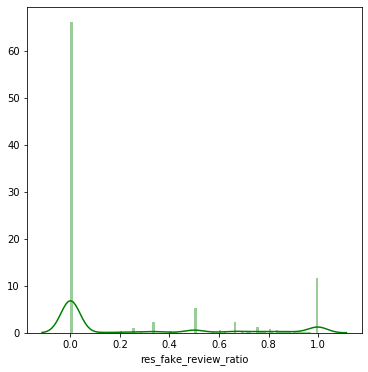

In [58]:
print(df_restaurant['res_fake_review_ratio'].describe())
plt.figure(figsize=(6, 6))
sns.distplot(df_restaurant['res_fake_review_ratio'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Review Content EDA

In [59]:
df.processed_text

0         good choice chicago friend final meal head air...
1         takashi fan bit hesitant going well glad gave ...
2         read star review spent includes tip adult kid ...
3         must called slurping turtle service slow turtl...
4         surprised place getting many negativemediocre ...
                                ...                        
411375    place great barbeque wonderful selection beer ...
411376    tiny little restaurant kind beaten path true n...
411377    pasha really turkish place visited earlier yea...
411378    far best consistent restaurant norfolk le doze...
411379    want great cajuncreole meal hampton road big e...
Name: processed_text, Length: 411380, dtype: object

In [61]:
df['polarity'] = df['processed_text'].swifter.apply(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['reviewContent'].astype(str).apply(len)
df['word_count'] = df['reviewContent'].apply(lambda x: len(str(x).split()))

In [63]:
# 5 random reviews with the highest positive sentiment polarity
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = df.loc[df.polarity == 1, ['reviewContent']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

The Best Thai food on the Monterey Peninsula!
Awesome almond croissants and macaroons.  Their almond croissant lives up to the hype and is the best almond croissant I have ever had!
Aside for the fact that they are taking it on the road by opening otra locations (loop and Chicago Ave) don't forget where your roots are and let the Flagship sink. Excellent dining and service as always waiters or tresses whatever need to attend a few Finishing School sessions tho.
Best in the world.
The pancakes here are the best!


In [64]:
# 5 random reviews with the most neutral sentiment polarity
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = df.loc[df.polarity == 0, ['reviewContent']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

I like it here :) more upscales than Emil's.
Tuna tartar is to die for! Always a go to when choosing a sushi spot
Food: 4/5. Service: 2/5.
This is a spot for people.  If you gave it below three stars you are not my people.  Back to your caves ignants!
This place is just so unfriendly and has nothing vegetarian at all!!


In [65]:
# 5 random reviews with the most negative sentiment polarity
print('2 reviews with the most negative polarity: \n')
cl = df.loc[df.polarity == -1, ['reviewContent']].sample(2).values
for c in cl:
    print(c[0])

2 reviews with the most negative polarity: 

Tasty stuff. Went twice during my 5 day stay in NYC. Servers are helpful and don't rush you despite the insane amount of people waiting for tables.
The tuna fish sandwich was absolutely disgusting. I couldn't even eat it.


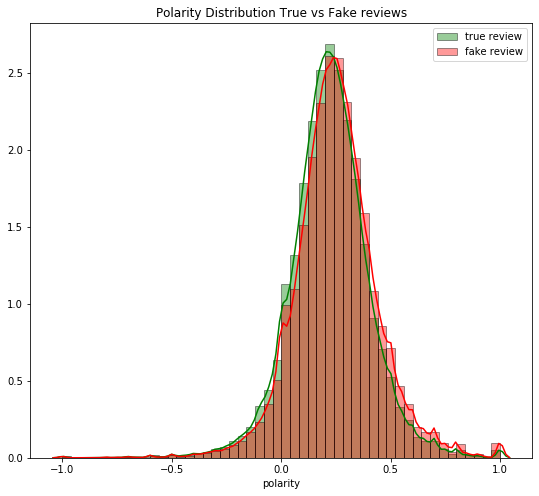

In [70]:
# polarity distribution
plt.figure(figsize=(9, 8))
fake = df[df.flagged == 1]
real = df[df.flagged == 0]

sns.distplot(real['polarity'], color='green', label = 'true review', bins=50, hist_kws={'alpha': 0.4, "edgecolor": 'black'});
sns.distplot(fake['polarity'], color='red', label = 'fake review', bins=50, hist_kws={'alpha': 0.4, "edgecolor": 'black'});
plt.title('Polarity Distribution True vs Fake reviews')
plt.legend(labels=['true review','fake review'])


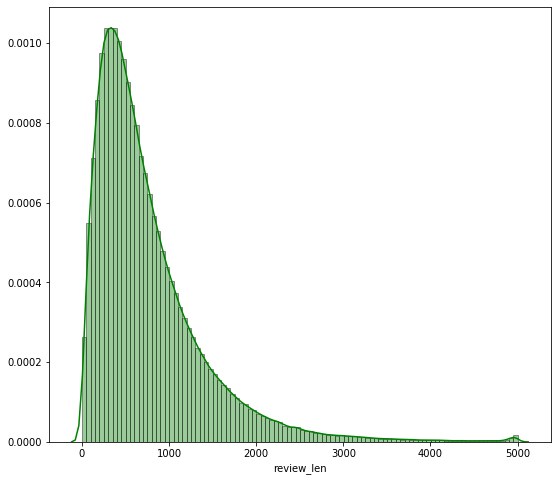

In [55]:
# review length distribution
plt.figure(figsize=(9, 8))
sns.distplot(df['review_len'], color='g', bins=100, hist_kws={'alpha': 0.4, "edgecolor": 'black'});

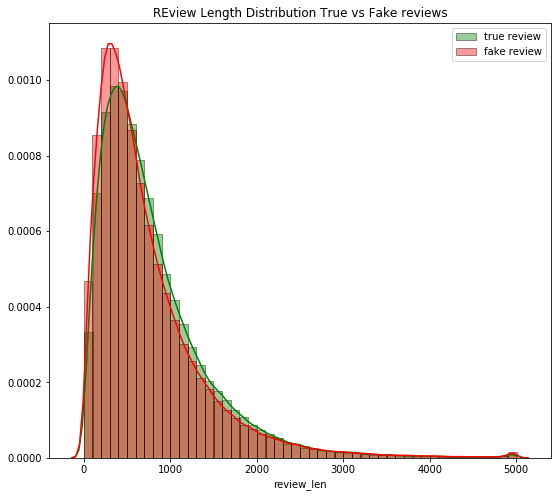

In [71]:
# polarity distribution
plt.figure(figsize=(9, 8))
fake = df[df.flagged == 1]
real = df[df.flagged == 0]

sns.distplot(real['review_len'], color='green', bins=50, hist_kws={'alpha': 0.4, "edgecolor": 'black'});
sns.distplot(fake['review_len'], color='red', bins=50, hist_kws={'alpha': 0.4, "edgecolor": 'black'});
plt.title('REview Length Distribution True vs Fake reviews')
plt.legend(labels=['true review','fake review'])


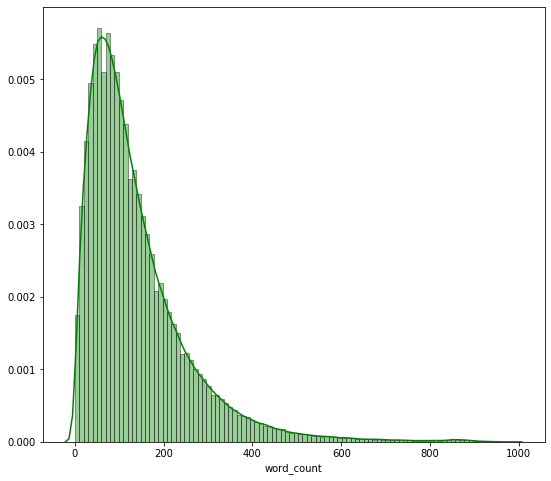

In [56]:
# word count distribution
plt.figure(figsize=(9, 8))
sns.distplot(df['word_count'], color='g', bins=100, hist_kws={'alpha': 0.4, "edgecolor": 'black'});

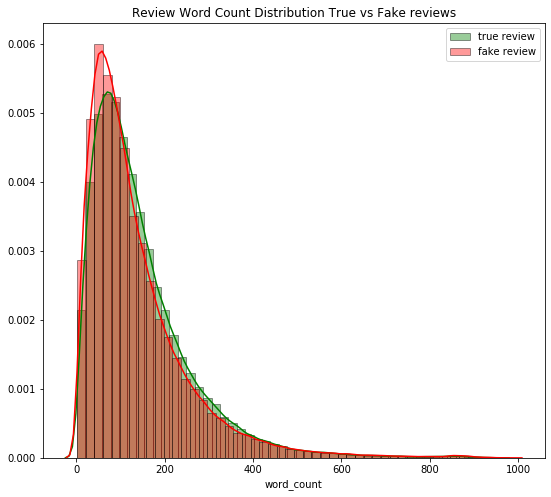

In [72]:
# polarity distribution
plt.figure(figsize=(9, 8))
fake = df[df.flagged == 1]
real = df[df.flagged == 0]

sns.distplot(real['word_count'], color='green', bins=50, hist_kws={'alpha': 0.4, "edgecolor": 'black'});
sns.distplot(fake['word_count'], color='red', bins=50, hist_kws={'alpha': 0.4, "edgecolor": 'black'});
plt.title('Review Word Count Distribution True vs Fake reviews')

plt.legend(labels=['true review','fake review'])


In [74]:
df['abs_polarity'] = df['polarity'].abs()
df['avg_polarity'] = df.groupby(['reviewerID'], as_index = False)['abs_polarity'].transform('mean')

df_reviewer = df_reviewer.merge(df[['reviewerID', 'avg_polarity']].drop_duplicates(subset = 'reviewerID'), on = 'reviewerID', how='inner')

In [75]:
# is avg_polarity calculated accurately??? Yes
df_reviewer.head()

,reviewerID,total_review,fake_review,fake_review_ratio,reviewer_name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,avg_polarity
0,--KQJPdrU0Md97DiOliDzw,130,79,0.607692,Steven C.,"Bellerose, NY",2006-01-01,87,163,9,277,169,140,135,13,5,0.220923
1,--KXo_HCYq9hB8NOdEUMKw,2,2,1.000000,Megan MJ J.,"Chicago, IL",2010-01-04,12,4,0,1,1,0,1,0,1,0.121288
2,--Qh8yKWAvIP4V4K8ZPfHA,55,2,0.036364,Dixie cream tea Q.,"Toronto, ON",2011-01-01,15,161,21,80,56,32,50,20,2,0.213624
3,--cDU5woxccqoHW5jzxJBw,4,4,1.000000,Brian J.,"Chicago, IL",2008-01-05,7,10,0,12,3,1,2,0,0,0.140835
4,--eQVss9nAx54FWsZHZgpA,11,9,0.818182,Kc Wildman W.,"Boulder, CO",2010-01-05,46,12,0,7,2,2,1,2,1,0.392062


Text(0.5, 1.0, 'Reviewer Average Polarity Distribution')

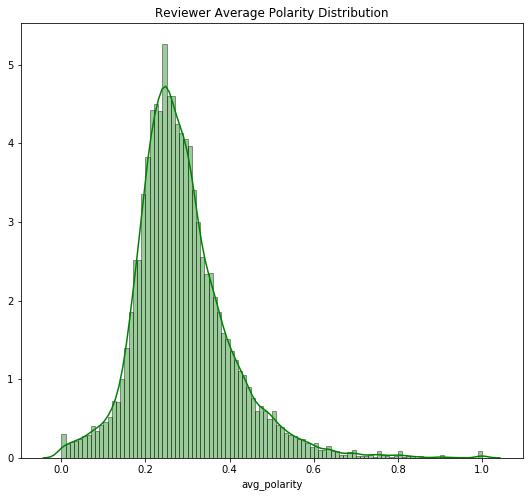

In [76]:
plt.figure(figsize=(9, 8))
sns.distplot(df_reviewer['avg_polarity'], color='g', bins=100, hist_kws={'alpha': 0.4, "edgecolor": 'black'});
plt.title('Reviewer Average Polarity Distribution')


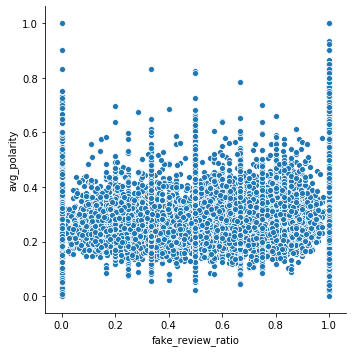

In [65]:
sns.relplot(x="fake_review_ratio", y="avg_polarity", data=df_reviewer)

### Average Review Length


In [66]:
df_test = df.groupby(['reviewerID'], as_index = False)['review_len'].agg({'total_length':'sum', 'num_reviews':'count'})
df_test['avg_length'] = df_test['total_length']/df_test['num_reviews']
df_reviewer = df_reviewer.join(df_test.drop(['total_length','num_reviews'],axis=1).set_index('reviewerID'), on = 'reviewerID')
df_reviewer.head(5)


,reviewerID,total_review,fake_review,fake_review_ratio,reviewer_name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,avg_polarity,avg_length
0,--KQJPdrU0Md97DiOliDzw,130,79,0.607692,Steven C.,"Bellerose, NY",2006-01-01,87,163,9,277,169,140,135,13,5,0.220923,656.876923
1,--KXo_HCYq9hB8NOdEUMKw,2,2,1.000000,Megan MJ J.,"Chicago, IL",2010-01-04,12,4,0,1,1,0,1,0,1,0.121288,751.500000
2,--Qh8yKWAvIP4V4K8ZPfHA,55,2,0.036364,Dixie cream tea Q.,"Toronto, ON",2011-01-01,15,161,21,80,56,32,50,20,2,0.213624,766.981818
3,--cDU5woxccqoHW5jzxJBw,4,4,1.000000,Brian J.,"Chicago, IL",2008-01-05,7,10,0,12,3,1,2,0,0,0.140835,1356.750000
4,--eQVss9nAx54FWsZHZgpA,11,9,0.818182,Kc Wildman W.,"Boulder, CO",2010-01-05,46,12,0,7,2,2,1,2,1,0.392062,183.636364


### Maximum Review Numbers per Day

In [67]:
from collections import Counter
reviewer_lst = df_reviewer.reviewerID.values.tolist()
maximum_review = dict.fromkeys(reviewer_lst)
reviewers = df.groupby(['reviewerID'])

for ID in reviewer_lst:
    reviewer = reviewers.get_group(ID)
    date_lst = reviewer.date.values.tolist()
    most_common,num_most_common = Counter(date_lst).most_common(1)[0]
    maximum_review[ID] = num_most_common
    
newdf = pd.DataFrame.from_dict(maximum_review, orient='index', columns=['max_review'])
newdf.index.name = 'reviewerID'
newdf.reset_index(inplace=True)
df_reviewer = df_reviewer.join(newdf.set_index('reviewerID'), on = 'reviewerID')
df_reviewer.head(5)

,reviewerID,total_review,fake_review,fake_review_ratio,reviewer_name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,avg_polarity,avg_length,max_review
0,--KQJPdrU0Md97DiOliDzw,130,79,0.607692,Steven C.,"Bellerose, NY",2006-01-01,87,163,9,277,169,140,135,13,5,0.220923,656.876923,8
1,--KXo_HCYq9hB8NOdEUMKw,2,2,1.000000,Megan MJ J.,"Chicago, IL",2010-01-04,12,4,0,1,1,0,1,0,1,0.121288,751.500000,2
2,--Qh8yKWAvIP4V4K8ZPfHA,55,2,0.036364,Dixie cream tea Q.,"Toronto, ON",2011-01-01,15,161,21,80,56,32,50,20,2,0.213624,766.981818,5
3,--cDU5woxccqoHW5jzxJBw,4,4,1.000000,Brian J.,"Chicago, IL",2008-01-05,7,10,0,12,3,1,2,0,0,0.140835,1356.750000,2
4,--eQVss9nAx54FWsZHZgpA,11,9,0.818182,Kc Wildman W.,"Boulder, CO",2010-01-05,46,12,0,7,2,2,1,2,1,0.392062,183.636364,10


### Extreme Rating Ratio

In [74]:
reviewer_lst = df_reviewer.reviewerID.values.tolist()
extreme_ratio = dict.fromkeys(reviewer_lst)
reviewers = df.groupby(['reviewerID'])

for ID in reviewer_lst:
    reviewer = reviewers.get_group(ID)
    rating_ID = reviewer.review_rating.values.tolist()
    extreme_ratio[ID] = (rating_ID.count(1)+rating_ID.count(5))/len(rating_ID)

newdf = pd.DataFrame.from_dict(extreme_ratio, orient='index', columns=['extreme_ratio'])
newdf.index.name = 'reviewerID'
newdf.reset_index(inplace=True)
df_reviewer = df_reviewer.join(newdf.set_index('reviewerID'), on = 'reviewerID')
df_reviewer.head()

,reviewerID,total_review,fake_review,fake_review_ratio,reviewer_name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,avg_polarity,avg_length,max_review,extreme_ratio
0,--KQJPdrU0Md97DiOliDzw,130,79,0.607692,Steven C.,"Bellerose, NY",2006-01-01,87,163,9,277,169,140,135,13,5,0.220923,656.876923,8,0.192308
1,--KXo_HCYq9hB8NOdEUMKw,2,2,1.000000,Megan MJ J.,"Chicago, IL",2010-01-04,12,4,0,1,1,0,1,0,1,0.121288,751.500000,2,0.500000
2,--Qh8yKWAvIP4V4K8ZPfHA,55,2,0.036364,Dixie cream tea Q.,"Toronto, ON",2011-01-01,15,161,21,80,56,32,50,20,2,0.213624,766.981818,5,0.127273
3,--cDU5woxccqoHW5jzxJBw,4,4,1.000000,Brian J.,"Chicago, IL",2008-01-05,7,10,0,12,3,1,2,0,0,0.140835,1356.750000,2,0.500000
4,--eQVss9nAx54FWsZHZgpA,11,9,0.818182,Kc Wildman W.,"Boulder, CO",2010-01-05,46,12,0,7,2,2,1,2,1,0.392062,183.636364,10,0.818182


### Rating Deviation from the Mean Rating

In [77]:
import statistics
res_lst = df.restaurantID.unique().tolist()
restaurant_avg_rating = dict.fromkeys(res_lst)
restaurants = df.groupby(['restaurantID'])

for ID in res_lst:
    res = restaurants.get_group(ID)
    rating_lst = res.rating.values.tolist()
    restaurant_avg_rating[ID] = statistics.mean(rating_lst)

newdf = pd.DataFrame.from_dict(restaurant_avg_rating, orient='index', columns=['restaurant_avg_rating'])
newdf.index.name = 'restaurantID'
newdf.reset_index(inplace=True)
df = df.join(newdf.set_index('restaurantID'), on = 'restaurantID')
df['rating_dev'] = abs(df['review_rating'] - df['restaurant_avg_rating'])
df.head()

,date,reviewID,reviewerID,reviewContent,review_rating,review_usefulCount,review_coolCount,review_funnyCount,flagged,restaurantID,...,restaurant_name,rating,processed_text,polarity,review_len,word_count,abs_polarity,avg_polarity,restaurant_avg_rating,rating_dev
0,2012-09-25,xvdJntJlo01tHu83-vXiRw,bNYesZ944s6IJVowOnB0iA,Good choice by our Chicago friends for our fin...,4,0,0,0,0,KU_Ze0TpR2HgKG2OpTh2NA,...,Slurping Turtle,3.5,good choice chicago friend final meal head air...,0.403125,404,66,0.403125,0.220077,3.5,0.5
1,2012-06-23,Z4oAUd6mIOhxxDsle3trPA,BSh3h1J4mdSmEsb8FFdf0Q,"I'm not a Takashi fan, so I was a bit hesitant...",4,0,0,0,1,KU_Ze0TpR2HgKG2OpTh2NA,...,Slurping Turtle,3.5,takashi fan bit hesitant going well glad gave ...,0.191304,838,151,0.191304,0.229850,3.5,0.5
2,2012-10-10,71c7BDude0l5tNjtxRZzMg,XVvbDeYn5Dk-MteNHwjC7Q,I should have read the the 3 stars and below r...,2,0,0,0,0,KU_Ze0TpR2HgKG2OpTh2NA,...,Slurping Turtle,3.5,read star review spent includes tip adult kid ...,0.187179,1418,263,0.187179,0.205952,3.5,1.5
3,2011-12-15,Vrzm2xmm2aBqBRqs3yK9Zw,om5ZiponkpRqUNa3pVPiRg,It must be called slurping turtle because thei...,3,8,3,4,1,KU_Ze0TpR2HgKG2OpTh2NA,...,Slurping Turtle,3.5,must called slurping turtle service slow turtl...,0.183707,1753,341,0.183707,0.232520,3.5,0.5
4,2012-09-07,coKi6jCbVd4qSUpoE5_0iA,LZt80LbsfQ9kOz96H7c1bA,I'm surprised this place is getting so many ne...,4,2,2,1,0,KU_Ze0TpR2HgKG2OpTh2NA,...,Slurping Turtle,3.5,surprised place getting many negativemediocre ...,0.297917,854,155,0.297917,0.285876,3.5,0.5


### Time Ratio of Review in All Reviews

In [78]:
restaurants = df.groupby(['restaurantID'])
time_ratio = []
dates = df.date.values.tolist()
print(dates[:5])

for index, row in  df.iterrows():
    df_ResID = restaurants.get_group(row['restaurantID'])
    sortedArray = sorted(df_ResID.date.values.tolist(),
                         reverse=True)
    x = sortedArray.index(int(dates[index]))
    if len(sortedArray)==1:
        time_ratio.append(1)
    else: 
        time_ratio.append(x/(len(sortedArray)-1))
df['time_ratio'] = time_ratio

[1348531200000000000, 1340409600000000000, 1349827200000000000, 1323907200000000000, 1346976000000000000]


In [79]:
df.head()

,date,reviewID,reviewerID,reviewContent,review_rating,review_usefulCount,review_coolCount,review_funnyCount,flagged,restaurantID,...,rating,processed_text,polarity,review_len,word_count,abs_polarity,avg_polarity,restaurant_avg_rating,rating_dev,time_ratio
0,2012-09-25,xvdJntJlo01tHu83-vXiRw,bNYesZ944s6IJVowOnB0iA,Good choice by our Chicago friends for our fin...,4,0,0,0,0,KU_Ze0TpR2HgKG2OpTh2NA,...,3.5,good choice chicago friend final meal head air...,0.403125,404,66,0.403125,0.220077,3.5,0.5,0.033333
1,2012-06-23,Z4oAUd6mIOhxxDsle3trPA,BSh3h1J4mdSmEsb8FFdf0Q,"I'm not a Takashi fan, so I was a bit hesitant...",4,0,0,0,1,KU_Ze0TpR2HgKG2OpTh2NA,...,3.5,takashi fan bit hesitant going well glad gave ...,0.191304,838,151,0.191304,0.229850,3.5,0.5,0.322222
2,2012-10-10,71c7BDude0l5tNjtxRZzMg,XVvbDeYn5Dk-MteNHwjC7Q,I should have read the the 3 stars and below r...,2,0,0,0,0,KU_Ze0TpR2HgKG2OpTh2NA,...,3.5,read star review spent includes tip adult kid ...,0.187179,1418,263,0.187179,0.205952,3.5,1.5,0.011111
3,2011-12-15,Vrzm2xmm2aBqBRqs3yK9Zw,om5ZiponkpRqUNa3pVPiRg,It must be called slurping turtle because thei...,3,8,3,4,1,KU_Ze0TpR2HgKG2OpTh2NA,...,3.5,must called slurping turtle service slow turtl...,0.183707,1753,341,0.183707,0.232520,3.5,0.5,0.855556
4,2012-09-07,coKi6jCbVd4qSUpoE5_0iA,LZt80LbsfQ9kOz96H7c1bA,I'm surprised this place is getting so many ne...,4,2,2,1,0,KU_Ze0TpR2HgKG2OpTh2NA,...,3.5,surprised place getting many negativemediocre ...,0.297917,854,155,0.297917,0.285876,3.5,0.5,0.077778


### Review Simililarity of Reviewer

In [80]:
# calculate cosine similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from statistics import mean

TfidfVec = TfidfVectorizer()
def cos_similarity(textlist):
    tfidf = TfidfVec.fit_transform(textlist)
    return (tfidf * tfidf.T).toarray()

group_reviewer = df.groupby('reviewerID')

reviewerIDs = df.reviewerID.unique()
df_reviewer_similarity = pd.DataFrame(columns=['reviewerID','ave_similarity','max_similarity'])

for reviewer in tqdm(reviewerIDs):
    review_content = group_reviewer.get_group(reviewer).processed_text.values.tolist()
    similarity = cos_similarity(review_content)
    ave_similarity = []
    max_similarity = []
    if len(similarity) > 1:
        for i in range(len(similarity)):
            average = np.delete(similarity[i], [i]).mean()
            maximum = np.delete(similarity[i], [i]).max()
            ave_similarity.append(average)
            max_similarity.append(maximum)
    else:
        ave_similarity.append(0)
        max_similarity.append(0)
        
    dict_reviewer = {}
    dict_reviewer['reviewerID'] = reviewer
    dict_reviewer['ave_similarity'] = mean(ave_similarity)
    dict_reviewer['max_similarity'] = max(max_similarity)
    df_temp = pd.DataFrame(dict_reviewer,index=[0])
    df_reviewer_similarity = df_reviewer_similarity.append(df_temp)
    
df = df.merge(df_reviewer_similarity, on = 'reviewerID', how = 'left')

100%|███████████████████████████████████████████████████████████████████████████| 14321/14321 [02:00<00:00, 118.42it/s]


In [144]:
df.head()

,date,reviewID,reviewerID,reviewContent,review_rating,review_usefulCount,review_coolCount,review_funnyCount,flagged,restaurantID,reviewer_name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurant_name,rating,processed_text,polarity,review_len,word_count,abs_polarity,avg_polarity,restaurant_avg_rating,rating_dev,time_ratio,ave_similarity,max_similarity
0,2012-09-25,xvdJntJlo01tHu83-vXiRw,bNYesZ944s6IJVowOnB0iA,Good choice by our Chicago friends for our fin...,4,0,0,0,0,KU_Ze0TpR2HgKG2OpTh2NA,Scott E.,"Glengary, WV",2009-01-10,11,48,5,41,5,5,2,0,1,Slurping Turtle,3.5,good choice chicago friend final meal head air...,0.403125,404,66,0.403125,0.220077,3.5,0.5,0.033333,0.064132,0.473407
1,2012-06-23,Z4oAUd6mIOhxxDsle3trPA,BSh3h1J4mdSmEsb8FFdf0Q,"I'm not a Takashi fan, so I was a bit hesitant...",4,0,0,0,1,KU_Ze0TpR2HgKG2OpTh2NA,Steven N.,"Chicago, IL",2010-01-07,34,116,2,93,16,19,10,0,2,Slurping Turtle,3.5,takashi fan bit hesitant going well glad gave ...,0.191304,838,151,0.191304,0.229850,3.5,0.5,0.322222,0.061079,0.268346
2,2012-10-10,71c7BDude0l5tNjtxRZzMg,XVvbDeYn5Dk-MteNHwjC7Q,I should have read the the 3 stars and below r...,2,0,0,0,0,KU_Ze0TpR2HgKG2OpTh2NA,Penny L.,"Cook County, IL",2007-01-12,2,14,1,5,1,3,0,4,1,Slurping Turtle,3.5,read star review spent includes tip adult kid ...,0.187179,1418,263,0.187179,0.205952,3.5,1.5,0.011111,0.027939,0.210318
3,2011-12-15,Vrzm2xmm2aBqBRqs3yK9Zw,om5ZiponkpRqUNa3pVPiRg,It must be called slurping turtle because thei...,3,8,3,4,1,KU_Ze0TpR2HgKG2OpTh2NA,Andrea W R.,"Chicago, IL",2006-01-01,3945,2063,347,12660,9617,6682,6948,605,503,Slurping Turtle,3.5,must called slurping turtle service slow turtl...,0.183707,1753,341,0.183707,0.232520,3.5,0.5,0.855556,0.044843,0.575308
4,2012-09-07,coKi6jCbVd4qSUpoE5_0iA,LZt80LbsfQ9kOz96H7c1bA,I'm surprised this place is getting so many ne...,4,2,2,1,0,KU_Ze0TpR2HgKG2OpTh2NA,Jessica N.,"Chicago, IL",2010-01-12,68,132,0,154,84,22,24,3,7,Slurping Turtle,3.5,surprised place getting many negativemediocre ...,0.297917,854,155,0.297917,0.285876,3.5,0.5,0.077778,0.052898,0.328510


In [83]:
df_reviewer.columns

Index(['reviewerID', 'total_review', 'fake_review', 'fake_review_ratio',
       'reviewer_name', 'location', 'yelpJoinDate', 'friendCount',
       'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount',
       'complimentCount', 'tipCount', 'fanCount', 'avg_polarity', 'avg_length',
       'max_review', 'extreme_ratio'],
      dtype='object')

In [84]:
df.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating',
       'review_usefulCount', 'review_coolCount', 'review_funnyCount',
       'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
       'funnyCount', 'complimentCount', 'tipCount', 'fanCount',
       'restaurant_name', 'rating', 'processed_text', 'polarity', 'review_len',
       'word_count', 'abs_polarity', 'avg_polarity', 'restaurant_avg_rating',
       'rating_dev', 'time_ratio', 'ave_similarity', 'max_similarity'],
      dtype='object')

In [88]:
new_cols = ['reviewerID','total_review', 'fake_review', 'fake_review_ratio', 'avg_length', 'max_review', 'extreme_ratio']
final_df = df.merge(df_reviewer[new_cols], on = 'reviewerID', how = 'left')

In [89]:
final_df.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating',
       'review_usefulCount', 'review_coolCount', 'review_funnyCount',
       'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
       'funnyCount', 'complimentCount', 'tipCount', 'fanCount',
       'restaurant_name', 'rating', 'processed_text', 'polarity', 'review_len',
       'word_count', 'abs_polarity', 'avg_polarity', 'restaurant_avg_rating',
       'rating_dev', 'time_ratio', 'ave_similarity', 'max_similarity',
       'total_review', 'fake_review', 'fake_review_ratio', 'avg_length',
       'max_review', 'extreme_ratio'],
      dtype='object')

In [93]:
final_df = final_df.merge(df_restaurant.drop('restaurant_name', 1), on = 'restaurantID', how = 'left')
final_df.shape

(411380, 44)

In [94]:
final_df.to_pickle('../data/final_df.pkl')